#### Write an anomaly detector for keywords

In [1]:
#Need to add parent directoy to sys.path to find 'metadataDB'
import sys
sys.path.append('../../')

%matplotlib inline
import matplotlib.pyplot as plt 
import time
import numpy as np

# Natural language processing toolkit
# To use this, run nltk.download() and download 'stopwords'
from nltk.corpus import stopwords
s=stopwords.words('english') + ['']

# Machine learning
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.pipeline import Pipeline
from sklearn import metrics

# SQL
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from metadataDB.declareDatabase import *
from sqlalchemy import or_, and_

# Anomaly Detector
import AnomalyDetector
reload(AnomalyDetector)

# json
# from json import json_util
import json

engine = create_engine("sqlite:///../../arXiv_metadata.db", echo=False)
Base.metadata.bind = engine
DBsession = sessionmaker(bind=engine)
session = DBsession()

/Users/emarti/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
categories = ['atom-ph', 'cond-mat', 'quant-ph', 'quant-gas', 'astro-ph', 'hep-ex']
# categories = ['atom-ph', 'quant-gas']

def get_abstracts(category):
    query = session.query(Article_Category)\
                    .join(Category)\
                    .join(Article)\
                    .filter(Category.name.like('%' + category + '%'))\
                    .order_by(Article.created)
    abstract = [x.article.abstract for x in query.all()]
    created = [x.article.created for x in query.all()]
    
    return (abstract, created)


In [3]:
class Articles():
    
    def __init__(self, category, session, num_top_words=100):
        '''category is the name of the arxiv category
        session is the SQLAlchemy session object'''
        self.category = category
        self.session = session
        self.num_top_words = num_top_words
        
        # I'm calling these immediately. Should I make this lazy instead?
        self.get_abstracts()
        self.calculate_tfidf()
    
    def get_abstracts(self):
        query = self.session.query(Article_Category)\
                        .join(Category)\
                        .join(Article)\
                        .filter(Category.name.like('%' + self.category + '%'))\
                        .order_by(Article.created)
        self.abstract = [x.article.abstract for x in query.all()]
        self.created = [x.article.created for x in query.all()]
    
    def calculate_tfidf(self):
        # Calculate tfidf
        self.vect = CountVectorizer(ngram_range=(1,3), stop_words='english')
        self.count = self.vect.fit_transform(self.abstract)
        self.tfidf = TfidfTransformer().fit_transform(self.count)

        self.featureToWord = self.vect.get_feature_names()

        self.top_features = np.asarray(self.tfidf.mean(axis=0))\
                                .argsort()[0,:-(self.num_top_words+1):-1]
        self.top_words = map(lambda x: self.featureToWord[x], self.top_features)
        
        
#         self.tfidf_sorted = np.array(tfidf.mean(axis=0).argsort())[0,::-1]
        self.tfidf_rank = { self.featureToWord[x]: (i+1) for i, x in enumerate(self.top_features) }


    
    def anomaly(self,
                     word,
                     blocksize=None,
                     display=False,
                     cutoff=3,
                     showProgress=False,
                     resample=True,
                     resample_points=300):
        feature = self.vect.vocabulary_[word]
    #     if source == 'counts':
    #         x = count[:, feature]
    #         poisson = True
    #     elif source == 'tfidf':
        x = self.tfidf[:, feature]
    #         poisson = False
    #     else:
    #         raise NameError('Source must be counts or tfidf')

        if blocksize == None:
            blocksize = x.shape[0]/15

        numBlocks = int(np.floor(self.tfidf.shape[0]/blocksize))

        self.detector = AnomalyDetector.ChangeDetector(x, blocksize, poisson=False, word=word)
        self.detector.iterate(display=display, showProgress=showProgress)
        
        # Convert things to lists rather than numpy so I can serialized them with json later.
        
        # Also, resample the moving average
        indexResample = np.linspace(0, len(self.detector.moving_average)-1, resample_points, dtype=np.int_)
        
        return {'moving_average': self.detector.moving_average[indexResample].tolist(),
                'index_moving_average': self.detector.index_moving_average[indexResample].tolist(),
                'created': [self.created[i].isoformat()
                            for i in self.detector.index_moving_average[indexResample].astype(np.int_)],
                'anomaly_mean': self.detector.mean.tolist(),
                'anomaly_std': self.detector.std.tolist(),
                'anomaly_steps': self.detector.anomaly.tolist(),
                'anomaly_index': self.detector.index.tolist(),
                'anomaly_error': self.detector.error,           
               }
    
def top_anomalies(article_object):
    '''Calculate and rank how anomalous are the top words (given tfidf ranking)
    from a set of articles.'''
    data = {}
    
    for word in article_object.top_words:
        output = article_object.anomaly(word)
        
#         new_dict = output.copy()
#         output.update( { 'tfidf_rank': article_object.tfidf_rank[word],
#                          'anomaly_rank': None,
#                           } )
        data[word] = {'tfidf_rank': article_object.tfidf_rank[word],
                      'anomaly_rank': None,
                      'moving_average': output['moving_average'],
                      'anomaly_mean': output['anomaly_mean'],
                      'anomaly_std': output['anomaly_std'],
                      'anomaly_steps': output['anomaly_steps'],
                      'anomaly_index': output['anomaly_index'],
                      'anomaly_error': output['anomaly_error'],           
                      }

    # Rank by how anomalous the results are
    i = 1
    words_sorted_anomaly = []
#     words_sorted_tfidf = []
    for x in sorted(data.iteritems(), key=lambda x: -x[1]['anomaly_error']):
        x[1]['anomaly_rank'] = i
        i += 1
        words_sorted_anomaly.append(x[0])
#     print words_sorted_anomaly
    
    # List of words ranked by tfidf
    words_sorted_tfidf = [x[0] for x in sorted(article_object.tfidf_rank.iteritems(), key=lambda x: x[1])]
#     print words_sorted_tfidf
    return {'data': data,
            'words_sorted_tfidf': words_sorted_tfidf,
            'words_sorted_anomaly': words_sorted_anomaly,
            'index_moving_average': output['index_moving_average'],
            'created': output['created']}


### Collect the data

In [4]:
num_top_words = 200
start = time.time()
data = {x: top_anomalies(Articles(x, session, num_top_words=num_top_words)) for x in categories}
print time.time() - start

2525.02017999


### Save the data

In [5]:
# def json_serial(obj):
#     """JSON serializer for objects not serializable by default json code"""

#     if isinstance(obj, datetime):
#         serial = obj.isoformat()
#         return serial

with open('anomaly.json', 'w') as f:
    json.dump(data, f)

### Plot the data.

atom-ph


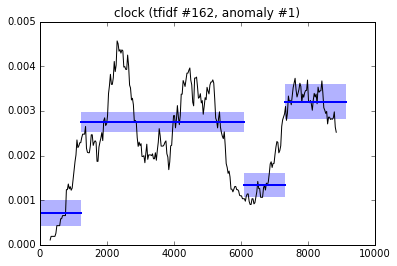

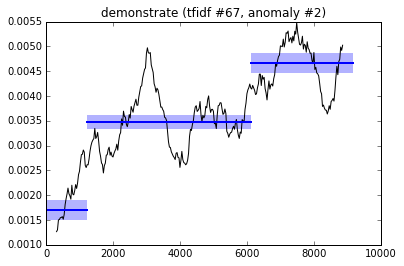

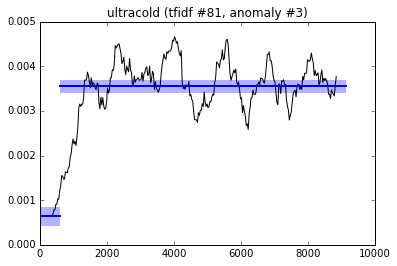

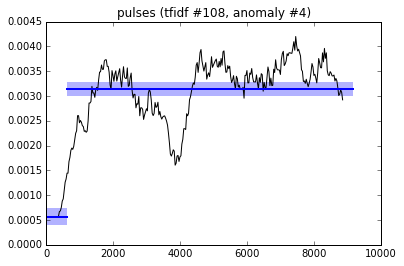

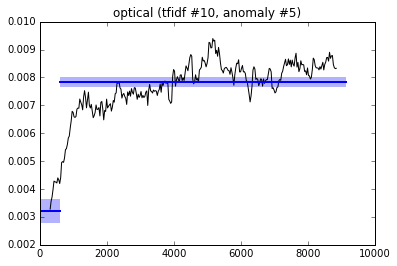

cond-mat


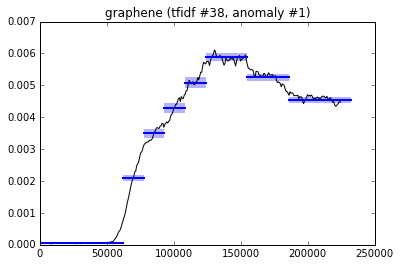

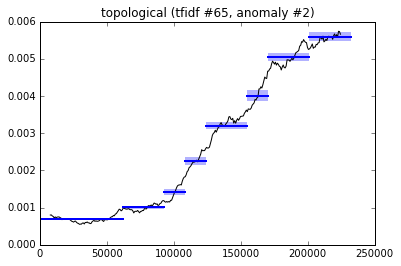

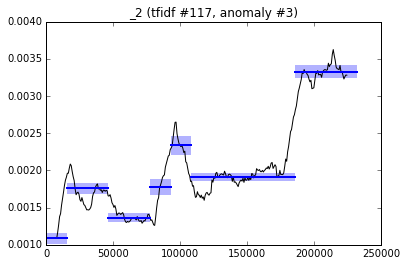

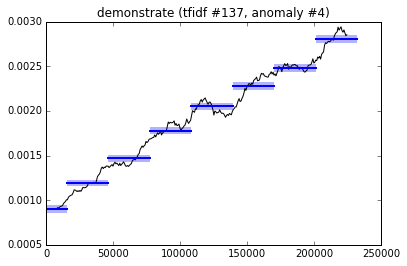

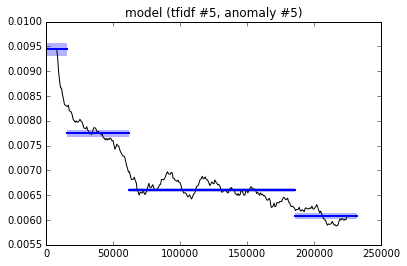

quant-ph


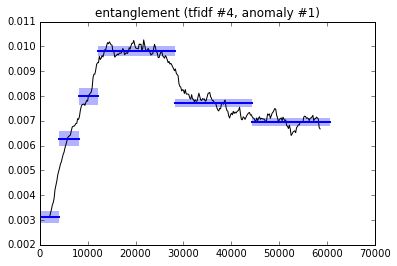

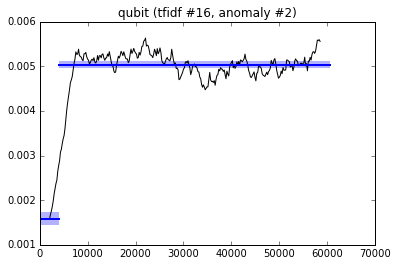

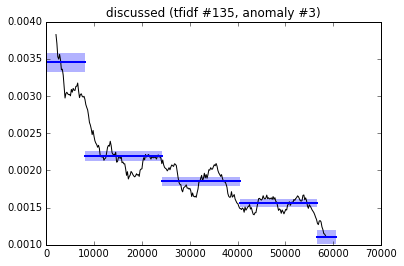

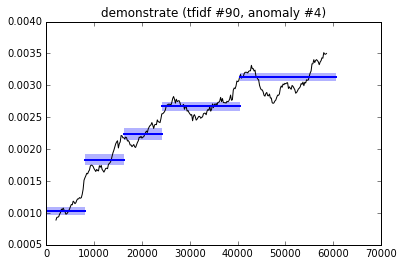

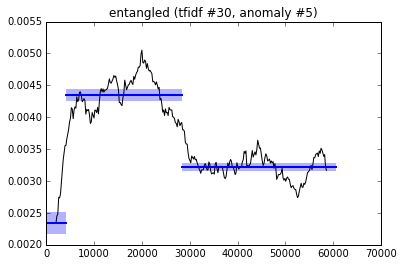

quant-gas


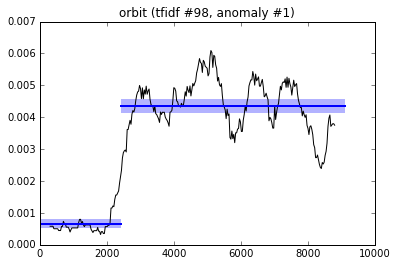

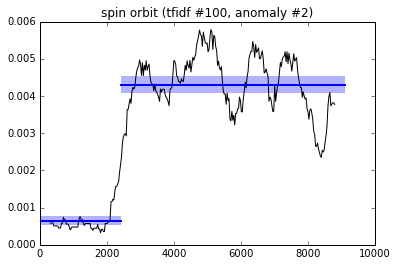

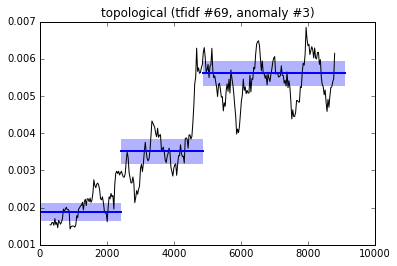

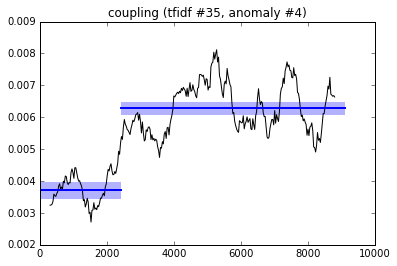

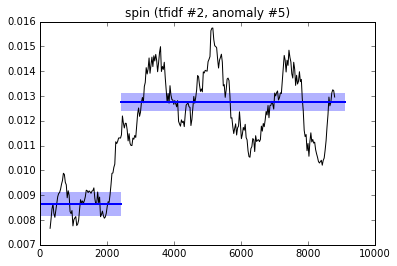

astro-ph


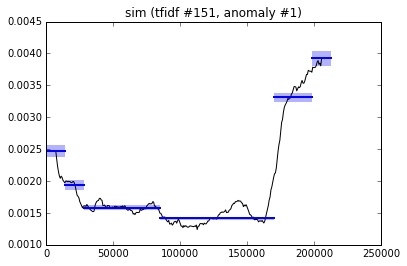

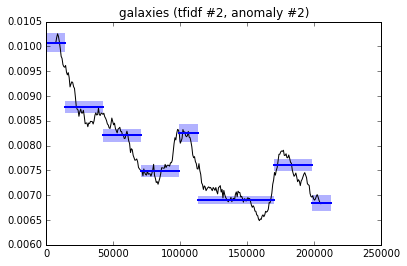

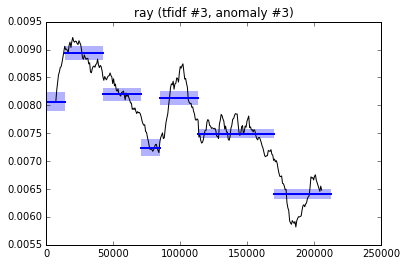

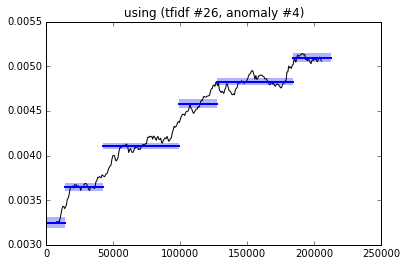

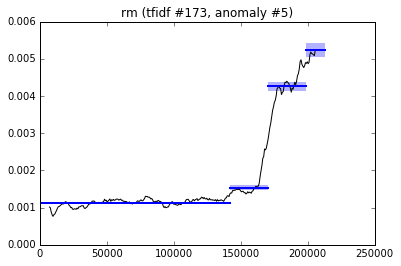

hep-ex


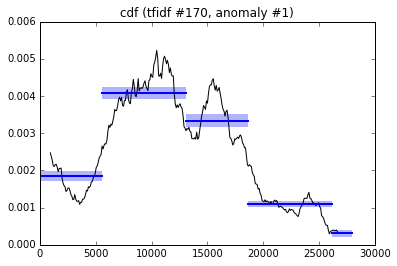

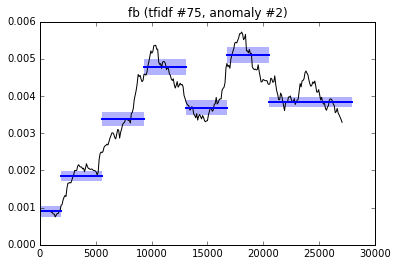

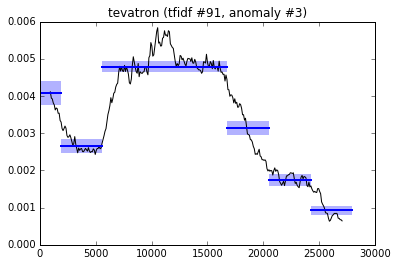

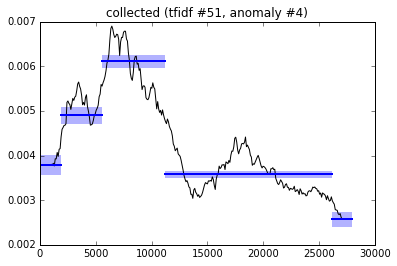

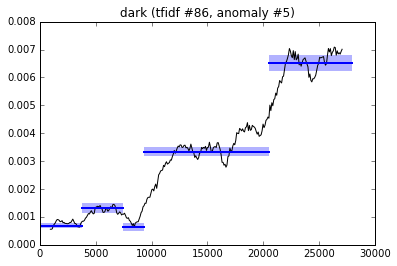

In [6]:
# Five most anomalous 
for category in categories:
    print category
    for word in data[category]['words_sorted_anomaly'][:5]:
#     for x in sorted(data_list[category].itertiems(), key=lambda y: y['anomaly_rank'])[:5]:
#         print 
        x = data[category]['data'][word]
        index = data[category]['index_moving_average']
#         print x.keys()
        plt.figure()
        plt.plot(index, x['moving_average'], 'k')
        AnomalyDetector.plotAnomaly(x['anomaly_mean'],
                                    x['anomaly_std'],
                                    x['anomaly_steps'],
                                    x['anomaly_index'])
        plt.title('{} (tfidf #{}, anomaly #{})'.format(word, x['tfidf_rank'], x['anomaly_rank']))
        plt.show()
    #     break